### Check point

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import re
import numpy as np
import pandas as pd
import lda
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE
import bokeh.plotting as bp
from bokeh.plotting import save
from bokeh.models import HoverTool
from string import digits
UN_full_text = pd.read_csv('data/UN_full_text.csv')
UN_full_text.head()

,ocr_eng
0,activities for regional nurses the regional nu...
1,to hug lien key map legend chingshu existing p...
2,the office of ohio t laepeetor serene that dor...
3,b ground water development in the muslin and c...
4,ten page 10 sodium bromide phonoborbital ferri...


In [2]:
remove_digits = str.maketrans('','',digits)
def remove_number(text):
    return text.translate(remove_digits)
UN_full_text = UN_full_text.ocr_eng.map(remove_number,na_action='ignore')

In [3]:
text_length = UN_full_text.map(len,na_action='ignore')
total_words = text_length.sum()
print ('There are total {:d} documents and {:d} words'.format(len(text_length),text_length.sum()))

There are total 1284 documents and 2097759 words


INFO:lda:n_documents: 1284
INFO:lda:vocab_size: 5007
INFO:lda:n_words: 165658
INFO:lda:n_topics: 10
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -1830236
INFO:lda:<10> log likelihood: -1394828
INFO:lda:<20> log likelihood: -1349247
INFO:lda:<30> log likelihood: -1333115
INFO:lda:<40> log likelihood: -1322625
INFO:lda:<50> log likelihood: -1317874
INFO:lda:<60> log likelihood: -1313840
INFO:lda:<70> log likelihood: -1309822
INFO:lda:<80> log likelihood: -1307745
INFO:lda:<90> log likelihood: -1305247
INFO:lda:<100> log likelihood: -1304166
INFO:lda:<110> log likelihood: -1302592
INFO:lda:<120> log likelihood: -1301894
INFO:lda:<130> log likelihood: -1299882
INFO:lda:<140> log likelihood: -1298689
INFO:lda:<150> log likelihood: -1298133
INFO:lda:<160> log likelihood: -1297201
INFO:lda:<170> log likelihood: -1296885
INFO:lda:<180> log likelihood: -1295796
INFO:lda:<190> log likelihood: -1295674
INFO:lda:<200> log likelihood: -1295095
INFO:lda:<210> log likelihood: -1294600
INFO:lda:<

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 728 samples in 0.001s...
[t-SNE] Computed neighbors for 728 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 728 / 728
[t-SNE] Mean sigma: 0.115823
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.578033
[t-SNE] Error after 1000 iterations: 0.244860


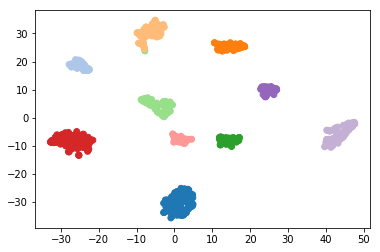

In [13]:
documents = UN_full_text.values
n_topics = 10 
n_iter = 500
n_top_words = 5
threshold = 0.5
cvectorizer = CountVectorizer(min_df=5, stop_words='english')
cvz = cvectorizer.fit_transform(documents)
lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter)
X_topics = lda_model.fit_transform(cvz)

_idx = np.amax(X_topics, axis=1) > threshold  # idx of news that > threshold
_topics = X_topics[_idx]
num_example = len(_topics)

tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(_topics[:num_example])

_lda_keys = []
for i in range(_topics.shape[0]):
    _lda_keys.append(_topics[i].argmax())

topic_summaries = []
topic_word = lda_model.topic_word_  # get the topic words
vocab = cvectorizer.get_feature_names()
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))

colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
])

plt.scatter(x=tsne_lda[:, 0], y=tsne_lda[:, 1],color=colormap[_lda_keys][:num_example])

In [15]:
title = "t-SNE visualization of LDA model".format(
    X_topics.shape[0], n_topics, threshold, n_iter, num_example, n_top_words)

plot_lda = bp.figure(plot_width=800, plot_height=600,
                   title=title,
                   tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                   x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x=tsne_lda[:, 0], y=tsne_lda[:, 1],
               color=colormap[_lda_keys][:num_example],
               source=bp.ColumnDataSource({
                 "content": documents[:num_example],
                 "topic_key": _lda_keys[:num_example]
                 }))

topic_coord = np.empty((X_topics.shape[1], 2)) * np.nan
for topic_num in _lda_keys:
    if not np.isnan(topic_coord).any():
          break
    topic_coord[topic_num] = tsne_lda[_lda_keys[topic_num]]

for i in range(X_topics.shape[1]):
    plot_lda.text(topic_coord[i, 0], topic_coord[i, 1], [topic_summaries[i]])

hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "@content - topic: @topic_key"}

save(plot_lda, 'TNT_UN_tsne_lda_viz.html')

/Users/yhhsu/Anaconda/anaconda/envs/NLP/lib/python3.6/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
/Users/yhhsu/Anaconda/anaconda/envs/NLP/lib/python3.6/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
/Users/yhhsu/Anaconda/anaconda/envs/NLP/lib/python3.6/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
/Users/yhhsu/Anaconda/anaconda/envs/NLP/lib/python3.6/site-packages/bokeh/util/deprecation.py:34: Bo

'/Users/yhhsu/Desktop/DataScience/NationalTreasure/TNT_UN_tsne_lda_viz.html'